In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from numba import jit, njit, float32, float64, vectorize


In [2]:
def Bmat(n, p, taps):
    assert(len(taps)>=5)
    I = np.eye(n)
    b = np.array([0] + taps + [0]*(p-len(taps)))

    brow = []
    for bi in b:
        brow.append(bi*I)
    brow = np.array(brow).reshape((p+1)*n,n).T

    B1 = []
    for i in range(0, p*n, n):
        if i > 0:
            B1.append(np.concatenate([np.array(list(np.zeros((n, n)))*(i//n)).T, brow[:, :-i]], axis=1))
        else:
            B1.append(brow)
            
    B1 = np.array(B1).reshape(p*n, (p+1)*n)

    ###########
    b = np.array([0] + [1,0,0,0,0] + [0]*(p-5))

    brow = []
    for bi in b:
        brow.append(bi*I)
    brow = np.array(brow).reshape((p+1)*n,n).T

    B2 = []
    for i in range(0, p*n, n):
        if i > 0:
            B2.append(np.concatenate([np.array(list(np.zeros((n, n)))*(i//n)).T, brow[:, :-i]], axis=1))
        else:
            B2.append(brow)

    B2 = np.array(B2).reshape(p*n, (p+1)*n)

    B = np.concatenate([B1, B2], axis=0)
    return B

def selmat(n, p):
    S = np.eye(p*n, p*n)
    S = np.concatenate([S, np.zeros((p*n, p*n))], axis=1)
    S = np.concatenate([S, np.zeros((p*n, 2*p*n))], axis=0)
    return S

def bias_selmat(n, p):
    b = np.concatenate([np.zeros((p*n, 1)), np.ones((p*n, 1))], axis=0)
    return b

def Lmat(n, p, taps):
    I_l = np.eye(p*n, p*n)
    L = np.concatenate([np.zeros((p*n, p*n)), I_l], axis=1)
    
    trow = []
    l = np.array(taps + [0]*(p-len(taps)))

    for li in l:
        trow.append(li*np.eye(n, n))

    trow = np.array(trow).reshape(p*n,n).T
    trow = np.concatenate([trow, np.zeros((n, n*p))], axis=1)
    
    L = np.concatenate([trow, L], axis=0)
    return L

def A_identity(n, p, A_block=None):
    I_l = np.eye((p-1)*n, (p-1)*n)
    I_l = np.concatenate([np.zeros(((p-1)*n, n)), I_l, np.zeros(((p-1)*n, n))], axis=1)

    if A_block is None:
        A_block = np.eye(n, n*p)

    connections = np.concatenate([np.zeros((n, n)), A_block], axis=1)
    I_u = np.concatenate([np.eye(n, n*(p+1)), connections], axis=0)
    A = np.concatenate([I_u, I_l], axis=0)
    return A

def f(x, n=2, p=10, A_block=None):
    B = Bmat(n, p, [1/9,2/9,3/9,2/9,1/9])
    S = selmat(n, p)
    b = bias_selmat(n, p)
    L = Lmat(n, p, [1/9,2/9,3/9,2/9,1/9])
    A = A_identity(n, p, A_block)
    
    return np.dot(A, L@np.diag(np.ravel(S@B@x + b))@(B@x))

def F_x(x, n=2, p=10, A_block=None):
    B = Bmat(n, p, [1/9,2/9,3/9,2/9,1/9])
    S = selmat(n, p)
    b = bias_selmat(n, p)
    L = Lmat(n, p, [1/9,2/9,3/9,2/9,1/9])
    A = A_identity(n, p, A_block=None)
    return np.dot(A, L@np.diag(np.ravel(B@x))@S@B + A@L@np.diag(np.ravel(S@B@x + b))@B)

def G(x, n=2, p=10):
    B = Bmat(n, p, [1/9,2/9,3/9,2/9,1/9])
    S = selmat(n, p)
    b = bias_selmat(n, p)
    L = Lmat(n, p, [1/9,2/9,3/9,2/9,1/9])
    return L@np.diag(np.ravel(B@x))@S@B + L@np.diag(np.ravel(S@B@x + b))@B

def g(x, n=2, p=10):
    B = Bmat(n, p, [1/9,2/9,3/9,2/9,1/9])
    S = selmat(n, p)
    b = bias_selmat(n, p)
    L = Lmat(n, p, [1/9,2/9,3/9,2/9,1/9])
    
    return L@np.diag(np.ravel(S@B@x + b))@(B@x)

In [38]:

def solve_for_q(q, s1, s2, a, lambda2, alpha=0.5, beta=0.1):
    """One-step sol to learn q, state-noise covariance matrix

    Parameters
    ----------
    q : ndarray of shape (n_sources, n_sources)
    s1 : ndarray of shape (n_sources, n_sources)
    s2 : nndarray of shape (n_sources, n_sources*order)
    a : ndarray of shape (n_sources, n_sources*order)
    lambda2 : float
    alpha: float, default = 0.5
    beta : float, default = 1

    Returns
    -------
    q : ndarray of shape (n_sources, n_sources)

    Notes
    -----
    non-zero alpha, beta values imposes Gamma(alpha*n/2 - 1, beta*n) prior on q's.
    This equivalent to alpha*n - 2 additional observations that sum to beta*n.
    """
    diag_indices = np.diag_indices_from(q)
    q_ = q[diag_indices]
    temp = np.einsum('ij,ji->i', a, s2.T)
    signa = np.sign(a)
    signa *= q_[:, None]
    temp2 = np.einsum('ij,ji->i', signa, a.T)
    temp2 *= lambda2
    # q_ = s1[diag_indices] + temp2 - temp
    if s1.ndim == 2:
        q_[:] = s1[diag_indices]
    else:
        q_[:] = s1
    q_ += temp2
    q_ -= temp
    # q_ /= t
    q_ += beta
    q_ /= (1 + alpha)
    q[diag_indices] = q_
    return q

def solve_for_a(q, s1, s2, a, lambda2, max_iter=5000, tol=1e-3, zeroed_index=None):
    """Gradient descent to learn a, state-transition matrix

    Parameters
    ----------
    q : ndarray of shape (n_sources, n_sources)
    s1 : ndarray of shape (n_sources, n_sources*order)
    s2 : ndarray of shape (n_sources*order, n_sources*order)
    a : ndarray of shape (n_sources, n_sources*order)
    lambda2 : float
    max_iter : int, default=1000
    tol : float, default=0.01
    zeroed_index : tuple of lists, like ([3, 3, 3], [1, 2, 3]).
        forces these indexes of a to 0.0.

    Notes
    -----
    To learn restricted model for i --> j, pass ([j] * p, list(range(i, m*p, m)))
    as zeroed index.

    Returns
    -------
    a : ndarray of shape (n_sources, n_sources*order)
    changes : list of floats
    """
    q = np.diag(q)
    qinv = 1 / q
    qinv = np.expand_dims(qinv, -1)
    # max step size:
    h_norm = qinv.max()
    h_norm *= np.linalg.eigvalsh(s2).max()
    tau = 0.99 / h_norm
    
    _a = np.empty_like(a)

    changes = np.zeros(max_iter+1)
    changes[0] = 1
    # grad = np.zeros_like(a)
    for i in range(max_iter):
        if changes[i] < tol:
            break
        _a[:] = a
        # Calculate gradient
        grad = np.dot(a, s2)
        grad -= s1
#         print(grad.shape, qinv.shape)
        grad *= qinv
#         print(grad.shape)
        # Find opt step-size
        # tau = 0.5 * (grad * grad).sum() / (np.diag(grad.dot(s2.dot(grad.T))) * qinv.ravel()).sum()
        temp = grad.dot(s2.T)
        den = ((temp * grad).sum(axis=1) * qinv.ravel()).sum()
        num = (grad * grad).sum()
        tau = 0.5 * num / den

        # Forward step
        temp[:] = a
        temp -= tau * grad

        # Backward (proximal) step
#         print(temp.shape, tau.shape)
        a = shrink(temp, lambda2 * tau)
        a = np.fabs(temp, out=a)
        a -= lambda2 * tau
        a = np.clip(a, a_min=0, a_max=None, out=a)
        a = np.copysign(a, temp, out=a)

        # f_ = (np.diag(a.dot(s2.dot(a.T)-2*s1.T)) * qinv.ravel()).sum()
        # fs.append(f_)

        if zeroed_index is not None:
            a[zeroed_index] = 0.0

        num = np.sum((_a - a) ** 2)
        den = np.sum(_a ** 2)
        changes[i+1] = 1 if den == 0 else np.sqrt(num / den)
    return a, changes

# @vectorize([float32(float32, float32),
#             float64(float64, float64)], cache=False)
# def shrink(x, t):
#     if x > t:
#         return x - t
#     elif x < -t:
#         return x + t
#     else:
#         return 0
def shrink(x, t):
    x_out = np.empty_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] > t:
                x_out[i,j] = x[i, j] - t
            elif x[i, j] < -t:
                x_out[i, j] = x[i, j] + t
            else:
                x_out[i, j] = 0
                
# def f_concat(x, a, n, p, p_prime):
#     x_e = g(x, n, p)
#     x_e_upper = x_e[:m]
#     x_e_lower = x_e[m:]



[[ 2.22207613 -1.6330803  -1.91133954 ...  0.02248067  0.11142601
  -1.56203602]
 [ 2.07681256  2.15941641 -0.77447793 ...  0.37140322 -1.61045801
   2.7022384 ]
 [-1.04496996  1.1818161   0.37218111 ... -0.82252183  2.23742503
  -0.58078392]
 ...
 [ 1.8588706  -0.158477   -0.54240653 ... -0.4804256   0.07105168
  -0.12984648]
 [ 2.12067349  1.0559506   0.31954508 ... -0.37329998 -0.82959348
   0.09589381]
 [-0.7195379   0.35499921 -0.50607672 ... -0.35265555 -0.02363579
   0.48096024]] (1000, 33)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.04496996  1.1818161   0.37218111 ... -0.82252183  2.23742503
  -0.58078392]
 ...
 [ 1.8588706  -0.158477   -0.54240653 ... -0.4804256   0.07105168
  -0.12984648]
 [ 2.12067349  1.0559506   0.31954508 ... -0.37329998 -0.82959348
   0.09589381]
 [-0.7195379   0.35499921 -0.50607672 ... -0.35265555 -0.02363579
   0.48096024]]
-2.3261412613109718
2

0.794573372027402
0.8928870559550683
-1.5167013170722579
6.319499908377834
5.451515977746901
-0.1590888649325255
-2.4594383424436645
-0.9606165513888512
-1.7907158037755768
-1.97891658728996
-2.7106463271467174
4.037714521218367
0.3460506346312344
3.473780649389073
-1.3924205782567902
-1.1535328450953317
-1.4354970792464177
4.3788647377616154
1.2907049996747506
3.5215333663339976
0.8481098133539884
1.7732198114680435
1.1776252133468108
4.63266954978485
1.8990495602981121
3.6130527882132224
1.7364564511420628
-2.9272089481413865
4.012186075333349
3.5790487890885863
0.5156535066850889
1.1805181129957592
6.4064681490075825
7.763432960066766
2.7399498976926555
5.197634548951938
-1.0824381390135729
5.256036414848758
4.200340120156427
0.689084460813083
2.574384277018553
1.112905999879715
4.437265584784515
4.106421069905441
5.085833626514346
0.6265225023688319
1.2082888068040185
1.7165851354309263
-0.7525059447161482
4.23223122914923
-1.3055762625542038
-3.1086132239674735
-4.650601700010197


-1.4146413947946073
0.3885710756963716
-1.1273129721655328
-2.0149480314330876
1.3071797462889634
1.7640994672386192
-0.13519263482757382
1.9231906395383183
-2.0097060718337314
1.6665331791208333
-0.04664973680125284
3.5657330752540757
-3.8980588415745676
3.012198525816779
-3.257931730140088
1.8616878385147857
1.9926399594725686
7.006435480512641
2.1189224823013824
-0.4515108239470882
-4.690582324149446
-3.021146014972323
-5.056860074691899
-1.6611709798881578
-5.244059057719225
-2.3027789829770793
-3.301681690752069
-2.0014497760949217
-3.1330051943715738
-2.685177597365948
-2.221612853197254
4.229637493050469
-3.772322282746803
2.5317700366388927
3.862801310013571
1.0728205260136698
1.6052520213321313
-0.3217808444425809
0.04926333073812428
0.7249289159491967
-4.044924068352866
-2.35468963182588
-2.7862336446204563
-0.9878054057088004
-3.8537398738361768
-1.263411198300359
-5.573557919174888
-0.7938691687621307
-0.18119986126763
3.8987948862334214
0.23195587302327358
2.94247857684486

/var/folders/6t/j6sybjn178x01p30mcfmpk600000gn/T/ipykernel_1158/417038576.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


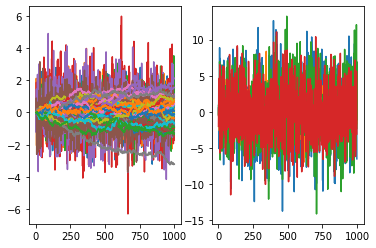

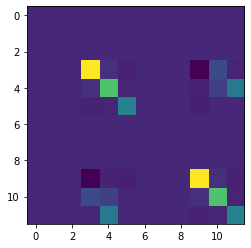

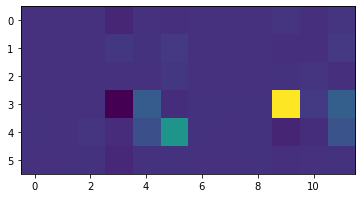

In [226]:
li = []
G_, hT_, states = None, None, None
def test_solve_for_a_and_q(t=1000):
    global li, G_, hT_, states
    # n, m = 155, 6*2*68
    n, m, p, p_full, k = 4, 3, 2, 10, 20
    q = 0.001 * np.eye((p_full+1)*m, (p_full+1)*m)

    for i in range(2*m):
        q[i, i] = 1
        
    r = np.eye(n)
    
    # standard normal state initialization
    sn = np.random.standard_normal((len(q) + n) * t)
    
    # u is the process noise vector for state evolution (m states at t time points)
    u = sn[:len(q) * t]
    u.shape = (t, len(q))
    
    # transform u to have noise covariance properties of the modeled system
    l = linalg.cholesky(q, lower=True)
    u = u.dot(l.T)
    
    # v is the observation noise vector (n observations at t time points)
    v = sn[len(q) * t:]
    v.shape = (t, n)
    
    # transform v to have noise covariance properties of the modeled system
    l = linalg.cholesky(r, lower=True)
    v = v.dot(l.T)
    
    # create a connectivity matrix
    a = np.zeros(p * 2*m * 2*m, dtype=np.float64)
    for i, val in zip(np.random.choice(p * 2*m * 2*m, k), np.random.randn(k)):
        a[i] = abs(val)
    a.shape = (p, 2*m, 2*m)
    for row in range(m):
        for col in range(m):
            for i in range(p):
                a[i][row, col] = 0 # e->e = 0 
                a[i][m+row, col] = 0 # e->x = 0
                a[i][row, m+col] = 0 # x->e = 0
                
    
    # ensure that the sum abs of rows (recall l1 norm of matrix is max l1  
    # norm of columns) of A does not exceed 1, else the eigs will be greater 
    # than 1 and the system will blow up with repeated applications of A
    a[0] /= 1.1 * linalg.norm(a[0])
    a[1] /= 1.1 * linalg.norm(a[1])
    
    # lf is the "lead field" matrix 
    lf = np.random.randn(n, 2*m)
    
    # x is the state vector
#     x = np.empty((t, 2*m), dtype=np.float64)
    x = np.random.standard_normal((t, len(q)))
    print(x, x.shape)
    x[0] = 0.0
    x[1] = 0.0
    print(x)
    
    def f(x):
#         x = x[m:2*m]
        x = g(x[:, np.newaxis], m, p_full)
        return x[:2*m].flatten()
#         return np.concatenate([x**2, x])
    
    for x_, _x, __x, u_ in zip(x[2:], x[1:], x, u):
        x_[:] = np.concatenate([a[0] @ f(_x) + a[1] @ f(__x),  _x[2*m:]]) + u_
        print(np.sum(x_))
        li.append(x_)
        
    li = np.array(li)
    y = x[:, :2*m].dot(lf.T) + v
    fig, ax = plt.subplots(1,2)
    ax[0].plot(x[:, :])
    ax[1].plot(y)
    fig.show()
    plt.show()
    
    states = x
    G_, hT_ = compute_G_hT(x)
    plt.imshow(G_)
    plt.show()
    plt.imshow(hT_)
    plt.show()
    s2 = G_
    s1 = hT_
#     x_bar = np.empty((t - 1, 2*m * p), dtype=np.float64)
#     for _x, __x, x_ in zip(x[1:], x, x_bar):
#         x_[:2*m] = _x[:2*m]
#         x_[2*m:] = __x[:2*m]
    
#     x_bar = np.empty((t - 1, m * p), dtype=np.float64)
#     for _x, __x, x_ in zip(x[1:], x, x_bar):
#         x_[:m] = _x
#         x_[m:] = __x
#     s1 = x[2:].T.dot(x_bar[:-1]) / (x_bar.shape[0] - p)
#     s2 = x_bar[:-1].T.dot(x_bar[:-1]) / (x_bar.shape[0] - p)
#     s3 = x[2:].T.dot(x[2:]) / (x_bar.shape[0] - p)

    a_ = np.zeros((2*m, 2*m * p))
    a_[:] = 0 * np.reshape(np.swapaxes(a, 0, 1), (2*m, 2*m * p))
    a_ = np.eye(2*m, 2*m*p)*0.001
#     q_ = 0.1 * q.copy()

    xcoords = []
    ycoords = []
    for i in [3,4,5,9,10,11]:
        for j in range(6):
            xcoords.append(j)
            ycoords.append(i)
    zi = (xcoords, ycoords)
#     zi = None
    for _ in range(20):
        a_, changes = solve_for_a(np.eye(6), s1, s2, a_, lambda2=6, max_iter=5000, tol=0.001, zeroed_index=zi)
#         a_, changes = solve_for_a(q_, s1, s2, a_, lambda2=0.1, max_iter=1000, tol=0.01)
#         q_ = solve_for_q(q_, s3, s1, a_, lambda2=0.1)
    return a_, a
#     ipdb.set_trace()
    
a_est, a_true = test_solve_for_a_and_q()

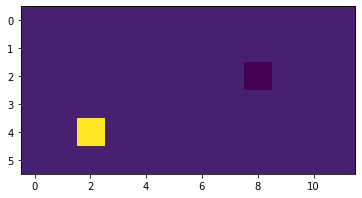

In [227]:
plt.imshow(a_est)

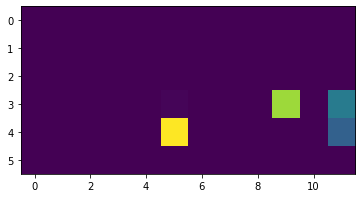

In [228]:
plt.imshow(np.concatenate([a_true[0], a_true[1]], axis=1))

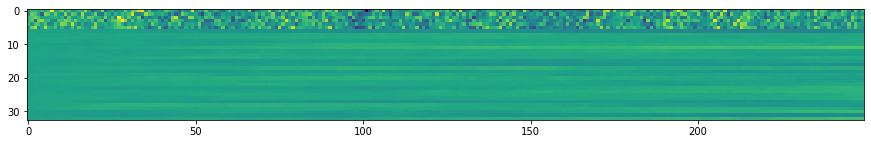

(array([2.44021485e+00, 2.32279401e+00, 9.13490529e-03, 8.92388540e-01,
        1.67589693e+00, 1.41267312e+00, 1.11296233e+00, 1.24421723e+00,
        1.20340127e+00, 8.89403879e-01, 2.96972256e-01, 2.13161687e-01,
        1.91960832e+00, 5.57043278e-01, 3.64180168e-01, 5.88828826e-01,
        2.10055689e-02, 2.99883183e-01, 8.48360306e-01, 1.41195754e+00,
        6.23374328e-01, 1.13054436e+00, 2.39124445e+00, 3.98815039e+00,
        9.21677622e-01, 2.98443367e-01, 2.68904343e+00, 3.59929197e+00,
        2.04204710e+00, 1.04723431e-01, 1.84386834e+00, 7.23243715e-02,
        7.95945189e-02, 7.83516964e-01, 1.03398369e+00, 2.75874159e-01,
        8.91961723e-01, 1.50714693e+00, 3.76555428e-01, 1.11848249e+00,
        1.07946618e-01, 3.21267063e-01, 1.20696020e+00, 2.97507664e+00,
        1.49262702e+00, 4.46688677e-01, 4.37335990e-01, 1.76192090e+00,
        1.50775196e+00, 1.00803590e+00, 3.34504887e-01, 1.56362768e-01,
        2.39859105e-01, 4.07952043e-01, 1.83657431e+00, 2.838753

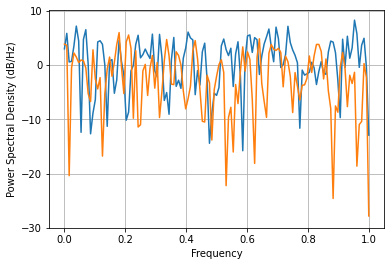

In [117]:
plt.figure(figsize=(15,10))
plt.imshow(li[:250].T)
plt.show()
plt.psd(li[:250, [0]])
plt.psd(li[:250, [4]])

In [118]:
# find G, x
def compute_G_hT(x):
    x_ = x[2:]
    _x = x[1:]
    __x = x[:]

    gM = np.zeros((1000-1, 6*2))

    PGMTGM = np.zeros((1000-1, 12, 12))
    P = 0.001 * np.eye((10+1)*3, (10+1)*3)

    for i in range(2*3):
        P[i, i] = 1

    for i, (_xi, __xi) in enumerate(zip(_x, __x)):
        gM[i] = np.concatenate([g(_xi[:, np.newaxis], 3, 10).flatten()[:6], g(__xi[:, np.newaxis], 3, 10).flatten()[:6]])
        GM = np.concatenate([G(_xi[:, np.newaxis], 3, 10)[:6, :6], G(__xi[:, np.newaxis], 3, 10)[:6,:6]], axis=1)
        PGMTGM[i] = np.eye(6*2)@GM.T@GM

    PGMTGM = np.mean(PGMTGM, axis=0)

    Gmatrix = gM.T@gM + PGMTGM

    ################

    hT = x_[:, :6].T @ gM[:-1]

    PGMT = np.zeros((1000-1, 6*2, 6))

    for _xi, __xi in zip(_x, __x): 
        PGMT[i] = np.eye(6*2) @ np.concatenate([G(_xi[:, np.newaxis], 3, 10)[:6, :6], G(__xi[:, np.newaxis], 3, 10)[:6,:6]], axis=1).T

    PGMT = np.mean(PGMT, axis=0)
    GMPT = PGMT.T

    hT = hT + 6*GMPT
    return Gmatrix, hT


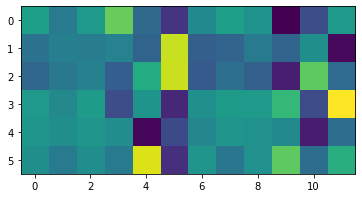

In [327]:
plt.imshow(hT)


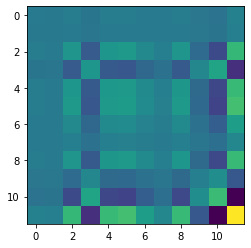

In [293]:
plt.imshow(gM.T@gM + PGMTGM)

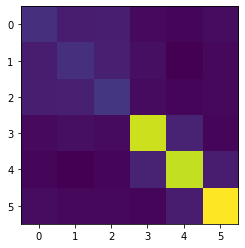

In [285]:
plt.imshow((gM.T@gM + PGMTGM)[:6, :6])

In [12]:
a = np.zeros((15,10))
for ix, (i, j) in enumerate(zip(a, a)):
    i[:] = ix

In [13]:
a

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.],
       [ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.],
       [ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.],
       [ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.],
       [ 9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.],
       [10., 10., 10., 10., 10., 10., 10., 10., 10., 10.],
       [11., 11., 11., 11., 11., 11., 11., 11., 11., 11.],
       [12., 12., 12., 12., 12., 12., 12., 12., 12., 12.],
       [13., 13., 13., 13., 13., 13., 13., 13., 13., 13.],
       [14., 14., 14., 14., 14., 14., 14., 14., 14., 14.]])